In [1]:
%load_ext autoreload 
%autoreload 2

In [35]:
import random
random.seed(42)
import numpy as np
np.random.seed(42)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
from sklearn import metrics
from sktime.classification.interval_based import CanonicalIntervalForest
from pathlib import Path
import config
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from preprocessing import dataPreProcess

In [3]:
def read_files(activity):
    dfs = []
    for file in config.DATA_FILES[activity]:
        filepath = Path(config.DATA_FOLDER, activity, file);
        with open(filepath, 'r') as file:
            raw_data = file.readlines()
            dfs.append(dataPreProcess(raw_data))
    dfs = [df.reset_index(drop = True) for df in dfs if not df is None]
    return dfs

In [4]:
activities = ['idle', 'jogging', 'after_exercise', 'exercise']
activity_labels = {'idle': 0, 'jogging': 1, 'after_exercise': 2, 'exercise': 3}

In [5]:
dfs = {}
for activity in activities:
    dfs[activity] = read_files(activity)

There are no valid SPO values, returning None


### Train and Test Split

In [6]:
def split_dataframes(df, sample_count):
    dfs = np.array_split(df, range(sample_count, len(df), sample_count), axis = 0)
    dfs = [_df.copy().reset_index(drop = True) for _df in dfs]
    return dfs

In [7]:
def prepare_datasets(dfs, sample_count=20):

    df_labels = {}
    max_series = 0
    for activity in dfs:
        df_labels[activity] = []
        for df in dfs[activity]:
            split_df = split_dataframes(df, sample_count)
            split_df = [_df for _df in split_df if len(_df) == sample_count]
            df_labels[activity].extend([(_df, activity_labels[activity]) for _df in split_df ])
            
        max_series = max(max_series, len(df_labels[activity]))
        
    for activity in df_labels:
        if len(df_labels[activity]) != max_series:
            df_labels[activity].extend(random.choices(df_labels[activity],k = max_series - len(df_labels[activity])))
    
    combined_df_labels = []
    for activity in df_labels:
        combined_df_labels.extend(df_labels[activity])
        
    random.shuffle(combined_df_labels)
    return list(zip(*combined_df_labels))

In [8]:
train_dfs = {}
test_dfs = {}

for activity in dfs:
    test_size = max(1, int(0.3 * len(dfs[activity])))
    train_dfs[activity] = dfs[activity][: len(dfs[activity]) - test_size]
    test_dfs[activity] = dfs[activity][len(dfs[activity]) - test_size:]
    
X_train, y_train = prepare_datasets(train_dfs, sample_count = 40)
X_test, y_test = prepare_datasets(test_dfs, sample_count = 40)

[Text(0.5, 1.0, 'Test data distribution'), Text(0.5, 0, 'Classes')]

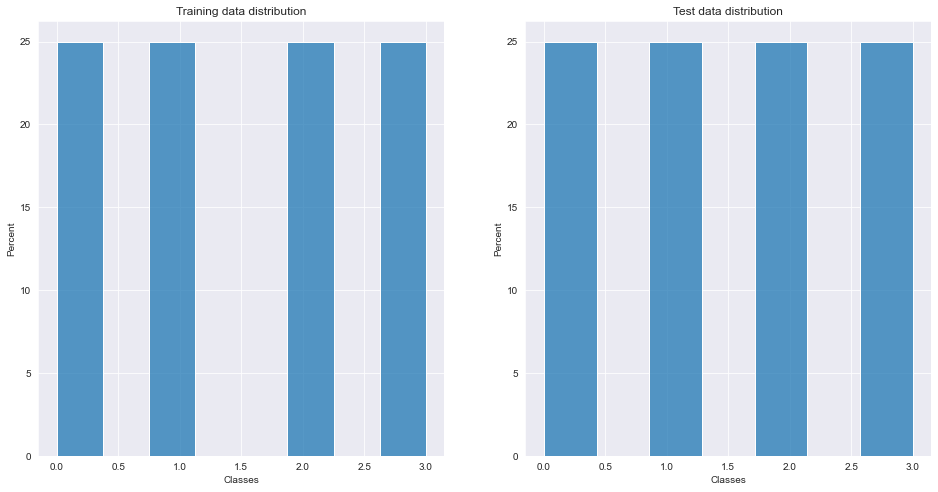

In [10]:
fig, axes = plt.subplots(ncols = 2, figsize = (16, 8))
sns.histplot(ax = axes[0], x = y_train, stat = 'percent').set(title = 'Training data distribution', xlabel = 'Classes')
sns.histplot(ax = axes[1], x = y_test, stat = 'percent').set(title = 'Test data distribution', xlabel = 'Classes')

### Canonical Interval Forest Classifier

In [17]:
def get_metric_score(y_true, y_pred):
    accuracy = metrics.accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred, average = 'micro')
    recall = metrics.recall_score(y_true, y_pred, average = 'micro')
    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    
    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'Confusion Matrix': confusion_matrix}

In [26]:
cif = CanonicalIntervalForest(n_estimators=5, att_subsample_size=20, random_state=42)
cif.fit(list(X_train), np.array(y_train))

CanonicalIntervalForest(att_subsample_size=20, n_estimators=5, random_state=42)

In [28]:
print('Training metrics:', get_metric_score(list(y_train), cif.predict(list(X_train))))

Training metrics: {'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'Confusion Matrix': array([[29,  0,  0,  0],
       [ 0, 29,  0,  0],
       [ 0,  0, 29,  0],
       [ 0,  0,  0, 29]], dtype=int64)}


In [30]:
print('Test metrics:', get_metric_score(list(y_test), cif.predict(list(X_test))))

Test metrics: {'Accuracy': 0.23333333333333334, 'Precision': 0.23333333333333334, 'Recall': 0.23333333333333334, 'Confusion Matrix': array([[ 8,  5,  1,  1],
       [ 8,  6,  1,  0],
       [15,  0,  0,  0],
       [ 4, 11,  0,  0]], dtype=int64)}


In [36]:
parameters = {'n_estimators': [1, 2, 3, 5, 10], 'att_subsample_size':[4, 8, 12, 16, 20], 'random_state': [42]}
scoring = {'accuracy': 'accuracy', 
           'precision' : metrics.make_scorer(metrics.precision_score, average = 'micro'), 
           'recall' : metrics.make_scorer(metrics.recall_score, average = 'micro')}
cif = CanonicalIntervalForest()
split_index = [-1]*len(X_train) + [0]*len(X_test)
X = list(X_train) + list(X_test)
y = np.concatenate((np.array(y_train), np.array(y_test)), axis=0)
pds = PredefinedSplit(test_fold = split_index)
clf = GridSearchCV(cif, parameters, scoring=scoring, refit = 'accuracy', cv = pds)
clf.fit(X, y)

GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             estimator=CanonicalIntervalForest(),
             param_grid={'att_subsample_size': [4, 8, 12, 16, 20],
                         'n_estimators': [1, 2, 3, 5, 10],
                         'random_state': [42]},
             refit='accuracy',
             scoring={'accuracy': 'accuracy',
                      'precision': make_scorer(precision_score, average=micro),
                      'recall': make_scorer(recall_score, average=micro)})

In [37]:
clf.best_estimator_

CanonicalIntervalForest(att_subsample_size=4, n_estimators=3, random_state=42)

In [38]:
clf.best_score_

0.23333333333333334

In [39]:
clf.best_params_

{'att_subsample_size': 4, 'n_estimators': 3, 'random_state': 42}

In [40]:
best_classifier = CanonicalIntervalForest(n_estimators=3, att_subsample_size=4, random_state=42)
best_classifier.fit(list(X_train), np.array(y_train))

CanonicalIntervalForest(att_subsample_size=4, n_estimators=3, random_state=42)

In [41]:
train_metrics = get_metric_score(list(y_train), best_classifier.predict(list(X_train)))
test_metrics = get_metric_score(list(y_test), best_classifier.predict(list(X_test)))

In [42]:
print('Training metrics:', train_metrics)
print('Testing metrics:', test_metrics)

Training metrics: {'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'Confusion Matrix': array([[29,  0,  0,  0],
       [ 0, 29,  0,  0],
       [ 0,  0, 29,  0],
       [ 0,  0,  0, 29]], dtype=int64)}
Testing metrics: {'Accuracy': 0.25, 'Precision': 0.25, 'Recall': 0.25, 'Confusion Matrix': array([[ 4,  5,  2,  4],
       [ 2,  6,  4,  3],
       [10,  0,  5,  0],
       [ 1, 10,  4,  0]], dtype=int64)}


[Text(0.5, 1.0, 'Test Confusion Matrix')]

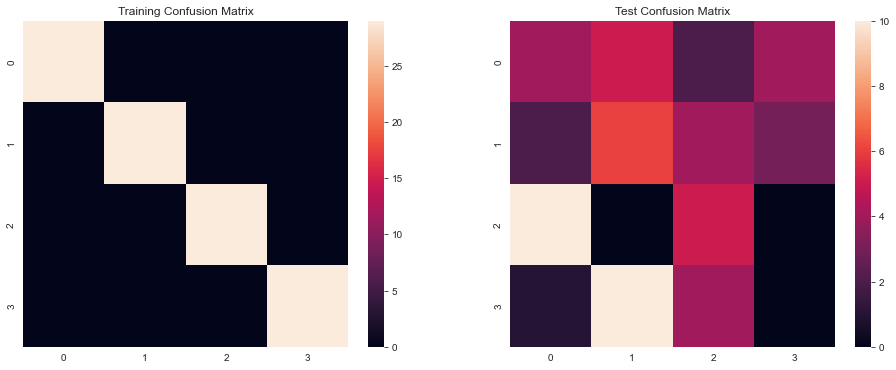

In [45]:
fig, axes = plt.subplots(ncols = 2, figsize = (16, 6))
sns.heatmap(ax = axes[0], data =train_metrics['Confusion Matrix']).set(title = 'Training Confusion Matrix')
sns.heatmap(ax = axes[1], data = test_metrics['Confusion Matrix']).set(title = 'Test Confusion Matrix')